In [4]:
import numpy as np
import pylab as plt

First read the file.

**Note** This file was produced with SQL query reported at https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors
 

In [5]:
data=np.genfromtxt('galaxyquasar.csv', delimiter=',',names=True,usecols=(0,1,2,3,4,6),dtype=float,comments='#')

In [6]:
names = data.dtype.names
names

('u', 'g', 'r', 'i', 'z', 'z1')

In [7]:
data=np.genfromtxt('galaxyquasar.csv', delimiter=',',skip_header=1,usecols=(0,1,2,3,4,6),dtype=float)

In [8]:
data

array([[18.97213   , 18.53676   , 18.5828    , 18.34936   , 18.29215   ,
         0.5228189 ],
       [19.24592   , 17.47646   , 16.47817   , 16.04472   , 15.68851   ,
         0.1228459 ],
       [19.43536   , 17.70268   , 16.91565   , 16.58327   , 16.39128   ,
         0.        ],
       ...,
       [18.62718   , 17.30876   , 16.87371   , 16.62399   , 16.42296   ,
         0.05442934],
       [19.5514    , 18.27711   , 17.62101   , 17.21947   , 17.03347   ,
         0.1125709 ],
       [18.80772   , 17.75751   , 17.405     , 17.2165    , 17.12295   ,
         0.04365238]])

In [9]:
d = dict(zip(names, data.T))
d

{'u': array([18.97213, 19.24592, 19.43536, ..., 18.62718, 19.5514 , 18.80772]),
 'g': array([18.53676, 17.47646, 17.70268, ..., 17.30876, 18.27711, 17.75751]),
 'r': array([18.5828 , 16.47817, 16.91565, ..., 16.87371, 17.62101, 17.405  ]),
 'i': array([18.34936, 16.04472, 16.58327, ..., 16.62399, 17.21947, 17.2165 ]),
 'z': array([18.29215, 15.68851, 16.39128, ..., 16.42296, 17.03347, 17.12295]),
 'z1': array([0.5228189 , 0.1228459 , 0.        , ..., 0.05442934, 0.1125709 ,
        0.04365238])}

In [11]:
lab=np.genfromtxt('galaxyquasar.csv', delimiter=',',skip_header=1,usecols=5,dtype=str)
lab

array(['QSO', 'GALAXY', 'GALAXY', ..., 'GALAXY', 'GALAXY', 'GALAXY'],
      dtype='<U6')

In [12]:
set(lab)

{'GALAXY', 'QSO'}

Let's build the colors

In [13]:
for diff in ['ug', 'gr', 'ri', 'iz']:
    d[diff]=d[diff[0]]-d[diff[1]] 
d['lab']=lab

In [14]:
d.keys()

dict_keys(['u', 'g', 'r', 'i', 'z', 'z1', 'ug', 'gr', 'ri', 'iz', 'lab'])

## A quick data exploration

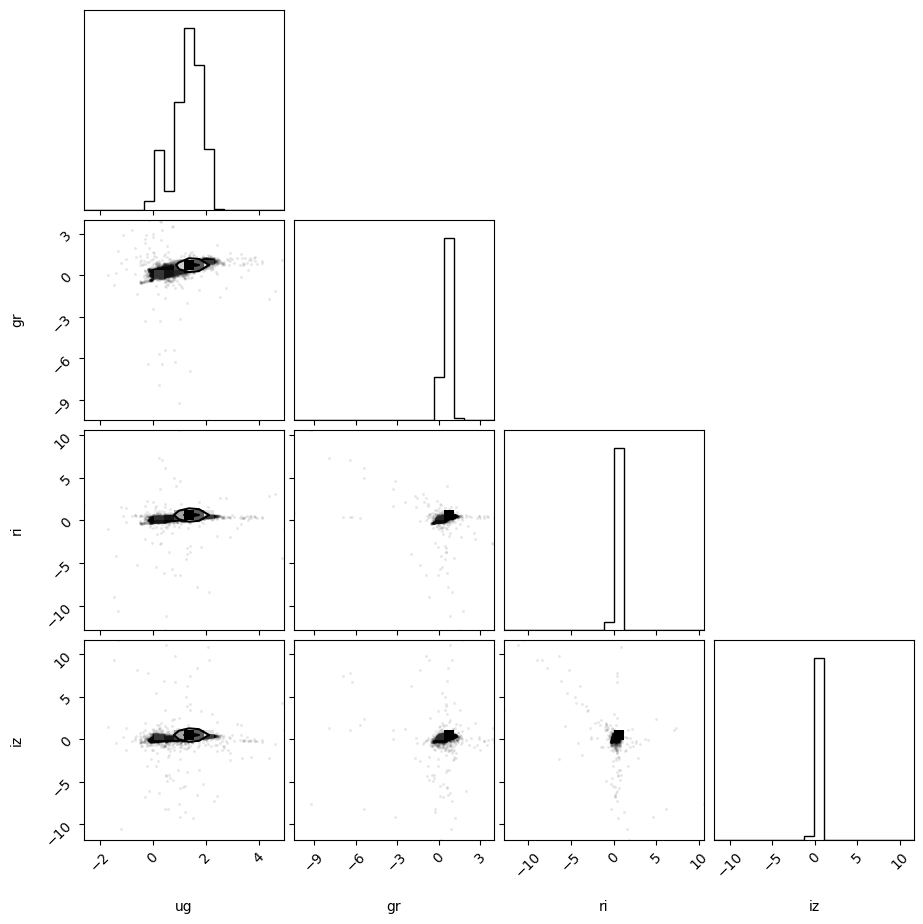

In [15]:
import corner
corner.corner(np.array([d['ug'],d['gr'],d['ri'],d['iz']]).T, labels=['ug', 'gr', 'ri', 'iz']);

There's a bimodality in the ug color...

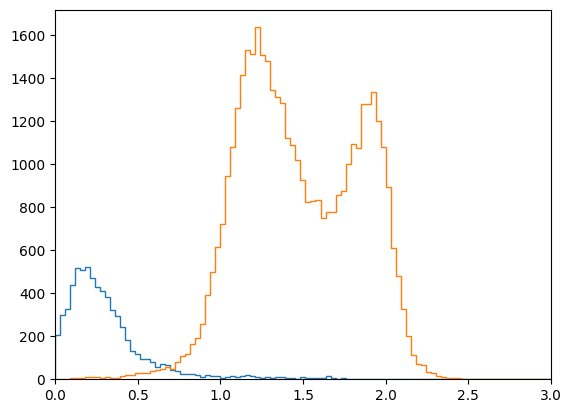

In [17]:
plt.hist(d['ug'][lab=='QSO'],histtype='step',bins=np.linspace(0,3,100))
plt.hist(d['ug'][lab=='GALAXY'],histtype='step',bins=np.linspace(0,3,100))
plt.xlim(0,3);

... which is indeed due to galaxies and quasars.

In [18]:
X=np.array([d['ug'], d['gr'], d['ri'], d['iz']]).T
y = np.array(lab=='QSO',dtype=int)

Get ready to machine learn

In [19]:
import sklearn.model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier


In [20]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=67)

In [18]:
X_train.shape

(33500, 4)

### Naive Bayes

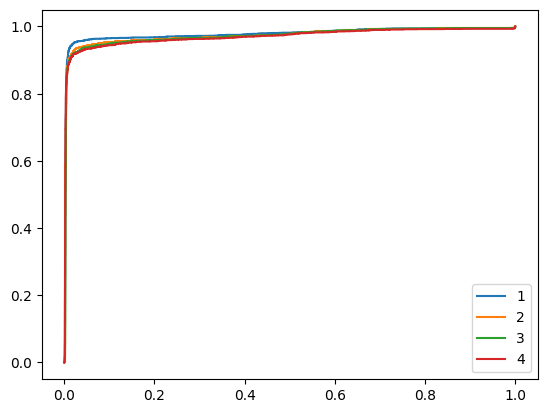

In [21]:
clf = GaussianNB()

for i in range(4):

    clf.fit(X_train[:,0:i+1] ,y_train )

    y_prob = clf.predict_proba(X_test[:,0:i+1]) [:,1] 
    
    
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=str(i+1))
plt.legend();

(33500, 1)
(33500, 2)
(33500, 3)
(33500, 4)


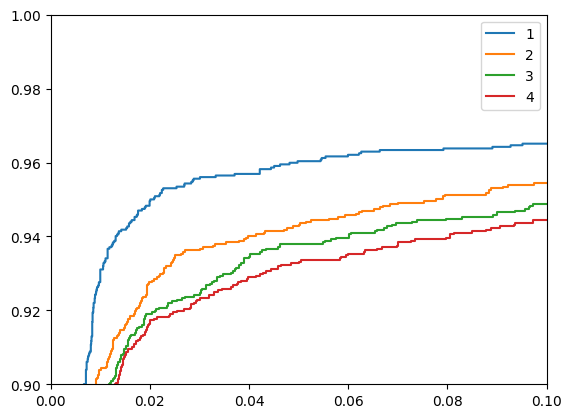

In [22]:
clf = GaussianNB()

for i in range(4):

    print( X_train[:,0:i+1].shape )

    clf.fit(X_train[:,0:i+1] ,y_train )

    y_prob = clf.predict_proba(X_test[:,0:i+1]) [:,1] 
    
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=str(i+1))
plt.legend()
plt.xlim(0,0.1)
plt.ylim(0.9,1);

The first feature is the only important one, we don't want a more complex model! Let's check with another model

## Quadratic Discriminant Analysis

(33500, 1)
(33500, 2)
(33500, 3)
(33500, 4)


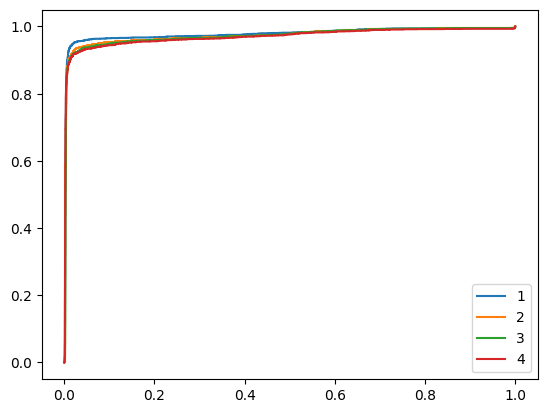

In [23]:
cfl = QuadraticDiscriminantAnalysis()

for i in range(4):

    print( X_train[:,0:i+1].shape )
    clf.fit(X_train[:,0:i+1] ,y_train )
    y_prob = clf.predict_proba(X_test[:,0:i+1]) [:,1] 
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=str(i+1))
    
plt.legend()

(33500, 1)
(33500, 2)
(33500, 3)
(33500, 4)


(0.9, 1.0)

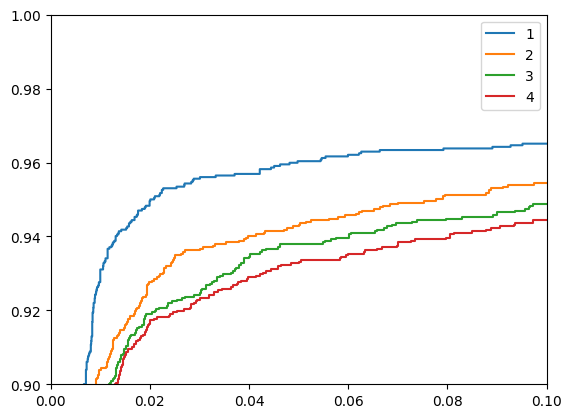

In [24]:
cfl = QuadraticDiscriminantAnalysis()

for i in range(4):

    print( X_train[:,0:i+1].shape )

    clf.fit(X_train[:,0:i+1] ,y_train )

    y_prob = clf.predict_proba(X_test[:,0:i+1]) [:,1] 
    
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=str(i+1))
plt.legend()
plt.xlim(0,0.1)
plt.ylim(0.9,1)

## GMMBayes


(0.9, 1.0)

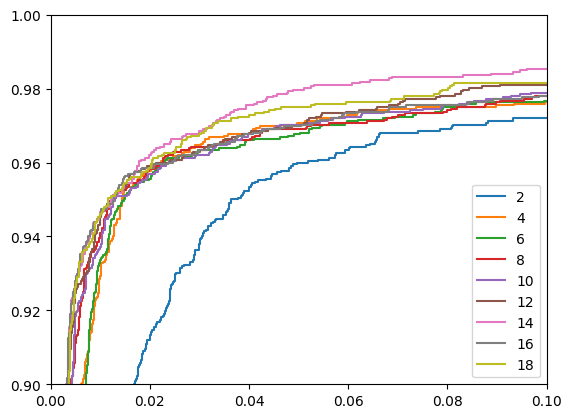

In [25]:
for n in np.arange(2,20)[::2]:
    
    clf = GMMBayes(n_components=n)
    clf.fit(X_train[:,0:4],y_train)
    
    y_prob = clf.predict_proba(X_test[:,0:4]) [:,1] 
        
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=str(n))

plt.legend()
plt.xlim(0,0.1)
plt.ylim(0.9,1)

## K Neighbors


(0.9, 1.0)

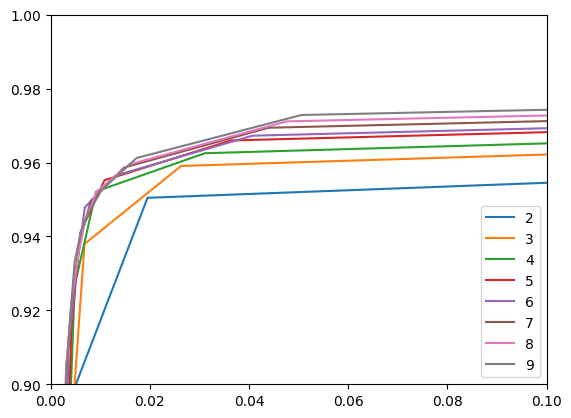

In [26]:
for n in np.arange(2,10):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_train[:,0:4],y_train)
    
    y_prob = clf.predict_proba(X_test[:,0:4]) [:,1] 
        
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=str(n))

plt.legend()
plt.xlim(0,0.1)
plt.ylim(0.9,1)

## Finishing up

In [30]:
clf = GMMBayes(n_components=4)
clf.fit(X_train[:,0:4],y_train)
y_pred = clf.predict(X[:,0:4]) 

(0.0, 3.0)

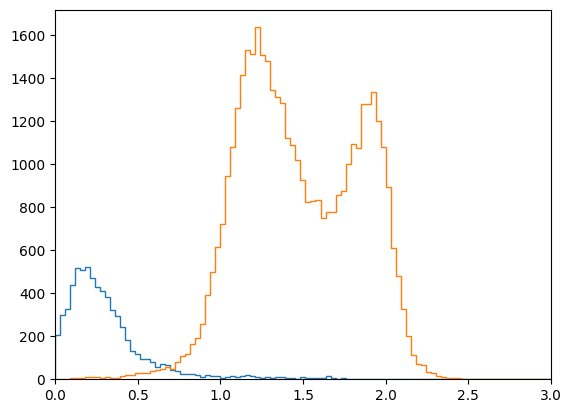

In [31]:
plt.hist(d['ug'][lab=='QSO'],histtype='step',bins=np.linspace(0,3,100))
plt.hist(d['ug'][lab=='GALAXY'],histtype='step',bins=np.linspace(0,3,100))
plt.xlim(0,3)

(0.0, 3.0)

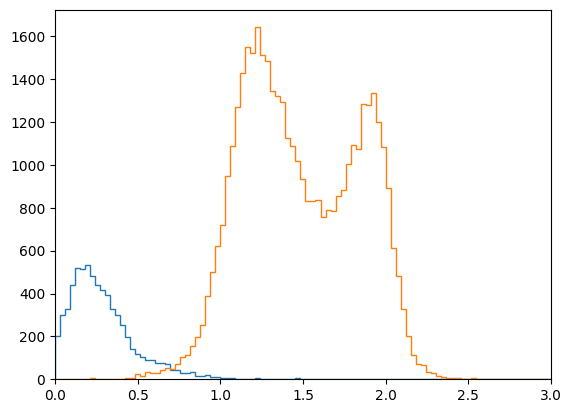

In [32]:
plt.hist(d['ug'][y_pred==1],histtype='step',bins=np.linspace(0,3,100))
plt.hist(d['ug'][y_pred==0],histtype='step',bins=np.linspace(0,3,100))
plt.xlim(0,3)

I like this (but note how in the last plot I've been sloppy and evaluated on the full X, both testing and training)